In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from matplotlib import pyplot as plt
import seaborn as sns
import gzip

test_file = './input/avazu-ctr-prediction/test.gz'
samplesubmision_file = './input/avazu-ctr-prediction/sampleSubmission.gz'

## 分块
使用chunk分块，把处理不过来的数据采样，相当于均匀采样0.05的数据进行分析

In [2]:
chunksize = 10 ** 6
num_of_chunk = 0
train = pd.DataFrame()
    
for chunk in pd.read_csv('./input/avazu-ctr-prediction/train.csv', chunksize=chunksize):
    num_of_chunk += 1
    train = pd.concat([train, chunk.sample(frac=.05, replace=False, random_state=123)], axis=0)
    print('Processing Chunk No. ' + str(num_of_chunk))     
    
train.reset_index(inplace=True)

#记录train的长度
train_len = len(train)
train_len

Processing Chunk No. 1
Processing Chunk No. 2
Processing Chunk No. 3
Processing Chunk No. 4
Processing Chunk No. 5
Processing Chunk No. 6
Processing Chunk No. 7
Processing Chunk No. 8
Processing Chunk No. 9
Processing Chunk No. 10
Processing Chunk No. 11
Processing Chunk No. 12
Processing Chunk No. 13
Processing Chunk No. 14
Processing Chunk No. 15
Processing Chunk No. 16
Processing Chunk No. 17
Processing Chunk No. 18
Processing Chunk No. 19
Processing Chunk No. 20
Processing Chunk No. 21
Processing Chunk No. 22
Processing Chunk No. 23
Processing Chunk No. 24
Processing Chunk No. 25
Processing Chunk No. 26
Processing Chunk No. 27
Processing Chunk No. 28
Processing Chunk No. 29
Processing Chunk No. 30
Processing Chunk No. 31
Processing Chunk No. 32
Processing Chunk No. 33
Processing Chunk No. 34
Processing Chunk No. 35
Processing Chunk No. 36
Processing Chunk No. 37
Processing Chunk No. 38
Processing Chunk No. 39
Processing Chunk No. 40
Processing Chunk No. 41


2021448

把test file也读进来，并和train file一起拼接在一起

In [3]:
df = pd.concat([train, pd.read_csv(test_file, compression='gzip')]).drop(['index', 'id'], axis=1)

把日期转化为weekday

In [4]:
def get_date(hour):
    y = '20'+str(hour)[:2]
    m = str(hour)[2:4]
    d = str(hour)[4:6]
    return y+'-'+m+'-'+d

df['weekday'] = pd.to_datetime(df.hour.apply(get_date)).dt.dayofweek.astype(str)

# 把hour转换为时间段
def tran_hour(x):
    x = x % 100
    while x in [23,0]:
        return '23-01'
    while x in [1,2]:
        return '01-03'
    while x in [3,4]:
        return '03-05'
    while x in [5,6]:
        return '05-07'
    while x in [7,8]:
        return '07-09'
    while x in [9,10]:
        return '09-11'
    while x in [11,12]:
        return '11-13'
    while x in [13,14]:
        return '13-15'
    while x in [15,16]:
        return '15-17'
    while x in [17,18]:
        return '17-19'
    while x in [19,20]:
        return '19-21'
    while x in [21,22]:
        return '21-23'

# 把hour转换为时间段
df['hour'] = df.hour.apply(tran_hour)

In [5]:
# 确认资料类别
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6598912 entries, 0 to 4577463
Data columns (total 24 columns):
 #   Column            Dtype  
---  ------            -----  
 0   click             float64
 1   hour              object 
 2   C1                int64  
 3   banner_pos        int64  
 4   site_id           object 
 5   site_domain       object 
 6   site_category     object 
 7   app_id            object 
 8   app_domain        object 
 9   app_category      object 
 10  device_id         object 
 11  device_ip         object 
 12  device_model      object 
 13  device_type       int64  
 14  device_conn_type  int64  
 15  C14               int64  
 16  C15               int64  
 17  C16               int64  
 18  C17               int64  
 19  C18               int64  
 20  C19               int64  
 21  C20               int64  
 22  C21               int64  
 23  weekday           object 
dtypes: float64(1), int64(12), object(11)
memory usage: 1.2+ GB


统计每个特征的value_count,发现即便是int类型的变量，其value count的数目也仅为4333，可认定所有的资料集都是object类型的

In [6]:
len_of_feature_count = []
for i in df.columns[2:23].tolist():
    print(i, ':', len(df[i].astype(str).value_counts()))
    len_of_feature_count.append(len(df[i].astype(str).value_counts()))

C1 : 7
banner_pos : 7
site_id : 3496
site_domain : 4333
site_category : 24
app_id : 5466
app_domain : 319
app_category : 31
device_id : 552856
device_ip : 1875405
device_model : 6321
device_type : 5
device_conn_type : 4
C14 : 2662
C15 : 8
C16 : 9
C17 : 470
C18 : 4
C19 : 68
C20 : 169
C21 : 62


In [7]:
# 建一个list，把需要转换成str的特征都装进去，方便下一步操作
need_tran_feature = df.columns[2:4].tolist() + df.columns[13:23].tolist()

# 把所有的特征变成string
for i in need_tran_feature:
    df[i] = df[i].astype(str)

一些特征的value count極高，此时如果用one-hot编码，会造成维度崩溃。在此将每个特征的维度的value count的上限设为10，如果超过十个，则使用下文缩减的方法。

缩减的方式：
计算value所有值的点击率，依据点击率分为 very_high, higher, mid, lower, very_low，等5个级距。

In [8]:
obj_features = []

for i in range(len(len_of_feature_count)):
    if len_of_feature_count[i] > 10:
        obj_features.append(df.columns[2:23].tolist()[i])
obj_features

['site_id',
 'site_domain',
 'site_category',
 'app_id',
 'app_domain',
 'app_category',
 'device_id',
 'device_ip',
 'device_model',
 'C14',
 'C17',
 'C19',
 'C20',
 'C21']

In [9]:
df_describe = df.describe()
df_describe

,click
count,2.021448e+06
mean,1.700731e-01
std,3.756971e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


In [25]:
def obj_clean(X):

    def get_click_rate(x):
        temp = train[train[X.columns[0]] == x]   #这里columns[0]，注意是大X（特征），x是特征的类型
        res = round((temp.click.sum() / temp.click.count()),3)   #这里
        return res
    
    def get_type(V, str):
        very_high = df_describe.loc['mean','click'] + 0.04
        higher = df_describe.loc['mean','click'] + 0.02
        lower = df_describe.loc['mean','click'] - 0.02
        very_low = df_describe.loc['mean','click'] - 0.04
    
        vh_type = V[V[str] > very_high].index.tolist()
        hr_type = V[(V[str] > higher) & (V[str] < very_high)].index.tolist()
        vl_type = V[V[str] < very_low].index.tolist()
        lr_type = V[(V[str] < lower) & (V[str] > very_low)].index.tolist()
    
        return vh_type, hr_type, vl_type, lr_type

    def clean_function(x):
# 判断依据：
#         +4%：very high 
#         +2%: higher  
#         -2%: low
#         -4%  very low
        while x in type_[0]:
            return 'very_high'
        while x in type_[1]:
            return 'higher'
        while x in type_[2]:
            return 'very_low'
        while x in type_[3]:
            return 'lower'
        return 'mid'
        
    print('Run: ', X.columns[0])
    fq = X[X.columns[0]].value_counts()
    # 建立一个暂存的资料列表
    # 舍弃frequency低于排名前1000 row的feature。
    if len(fq) > 1000:
        fq = fq[:1000]

    fq = pd.DataFrame(fq)
    fq['new_column'] = fq.index    

    # 使用index叫用get_click_rate function
    fq['click_rate'] = fq.new_column.apply(get_click_rate)

    type_ = get_type(fq, 'click_rate')

    return X[X.columns[0]].apply(clean_function)

for i in obj_features:

    df[[i]] = obj_clean(df[[i]]).to_frame()

df

Run:  site_id
Run:  site_domain
Run:  site_category
Run:  app_id
Run:  app_domain
Run:  app_category
Run:  device_id
Run:  device_ip
Run:  device_model
Run:  C14
Run:  C17
Run:  C19
Run:  C20
Run:  C21


,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday
0,1.0,01-03,1005,1,very_high,very_high,mid,higher,higher,higher,...,0,mid,320,50,mid,2,mid,mid,mid,1
1,0.0,01-03,1005,0,higher,higher,higher,higher,higher,higher,...,0,mid,320,50,mid,0,mid,mid,mid,1
2,0.0,01-03,1005,0,higher,higher,higher,higher,higher,higher,...,0,mid,320,50,mid,0,mid,mid,mid,1
3,0.0,03-05,1005,1,very_low,very_low,mid,higher,higher,higher,...,0,mid,320,50,mid,3,mid,mid,mid,1
4,0.0,01-03,1005,0,higher,higher,higher,higher,higher,higher,...,0,mid,320,50,mid,0,mid,mid,mid,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4577459,NaN,23-01,1005,0,very_high,very_high,very_high,higher,higher,higher,...,0,mid,300,250,mid,2,mid,mid,mid,4
4577460,NaN,23-01,1005,0,mid,higher,mid,higher,higher,higher,...,0,mid,320,50,mid,0,mid,mid,mid,4
4577461,NaN,23-01,1005,0,very_high,very_high,very_high,higher,higher,higher,...,0,mid,300,250,mid,2,mid,mid,mid,4
4577462,NaN,23-01,1005,0,very_low,very_low,very_low,very_low,very_low,very_low,...,3,mid,320,50,mid,1,mid,mid,mid,4


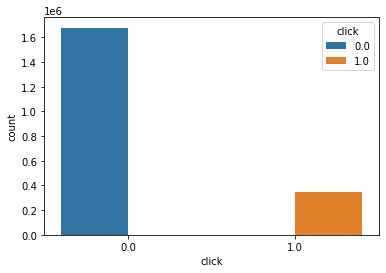

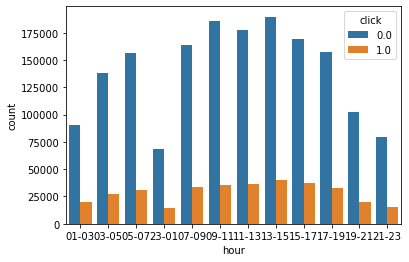

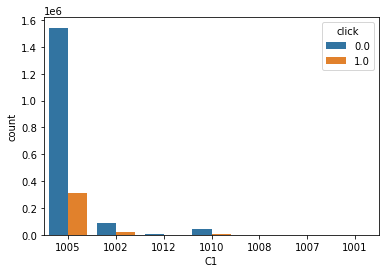

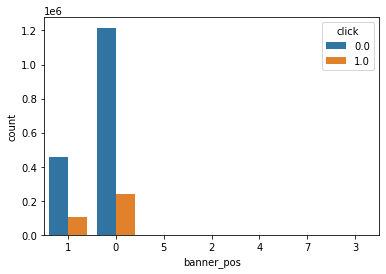

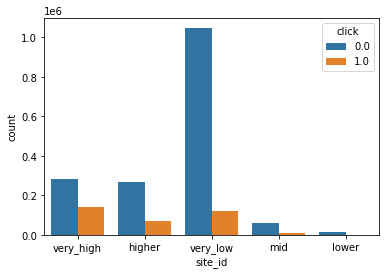

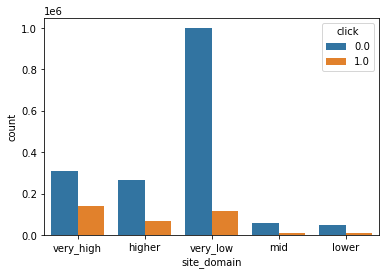

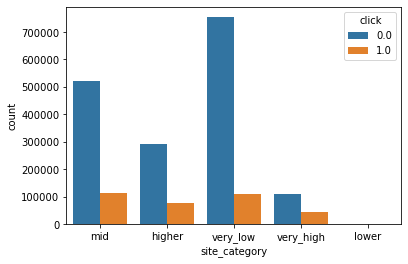

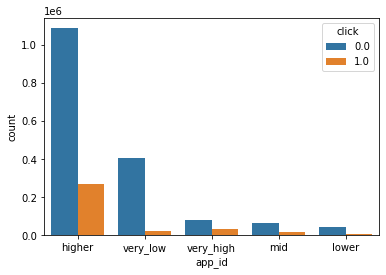

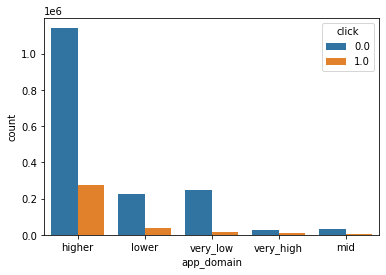

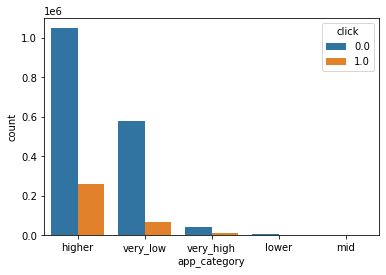

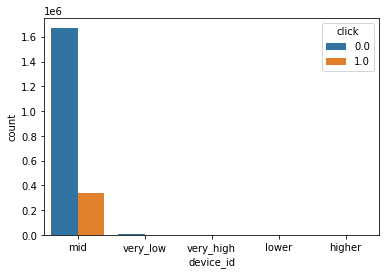

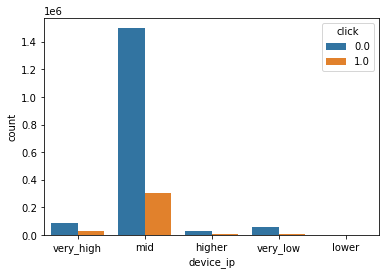

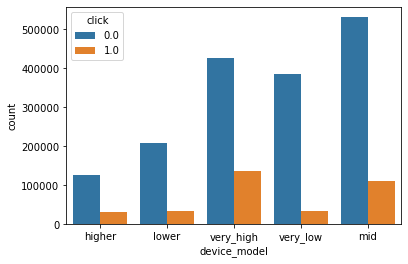

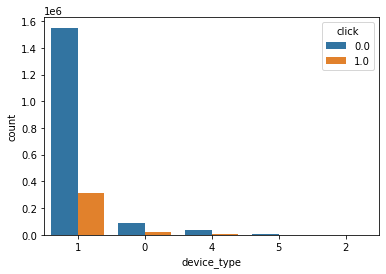

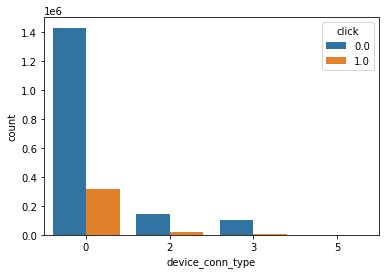

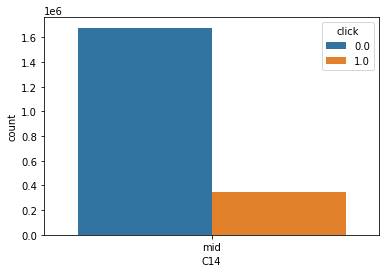

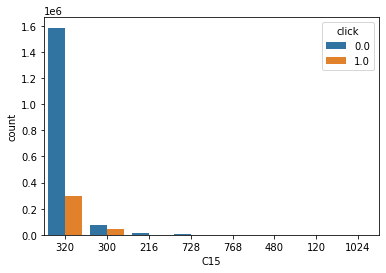

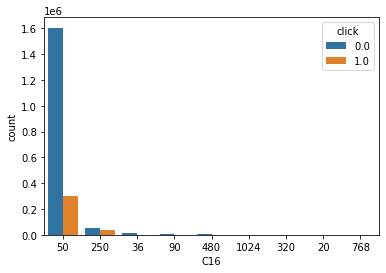

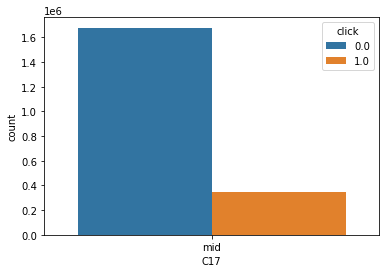

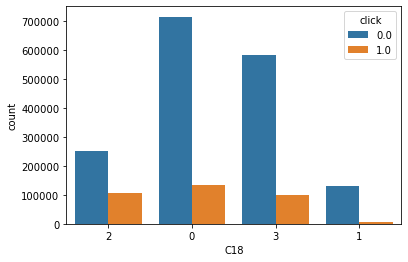

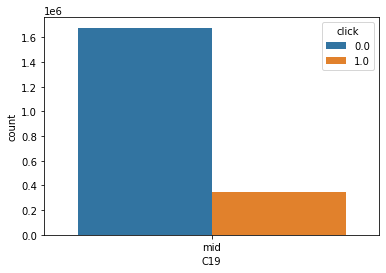

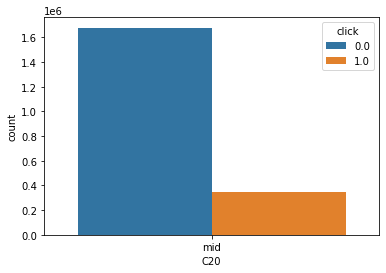

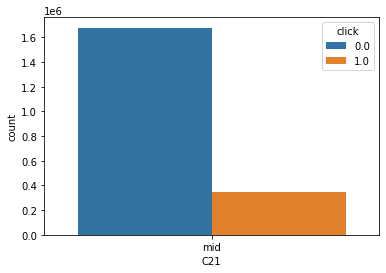

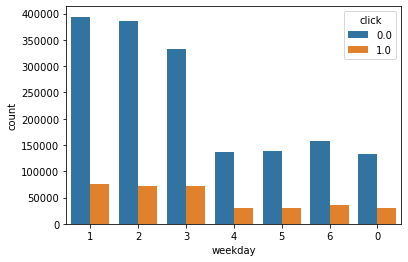

In [26]:
# 查看所有的特征分布
for i in df.columns:
    sns.countplot(x = i, hue = "click", data = df)
    plt.show()

In [27]:
df.drop(['device_id', 'C14', 'C17', 'C19', 'C20', 'C21'], axis=1, inplace=True)

In [28]:
# one-hot编码
df = pd.get_dummies(df)

#重新將train, test分割出來
train = df[:train_len]
test = df[train_len:]

In [29]:
# 取出特征工程后的数据

train.to_csv('new_train.csv', index=False)
test.to_csv('new_test.csv', index=False)

In [30]:
# 读入数据
train = pd.read_csv('new_train.csv')
test = pd.read_csv('new_test.csv')

In [31]:
del df

In [32]:
# 采样，使得label为0和1的数量相同
pre_X = train[train['click'] == 0].sample(n=len(train[train['click'] == 1]), random_state=111)
pre_X = pd.concat([pre_X, train[train['click'] == 1]]).sample(frac=1)
pre_y = pre_X[['click']]
pre_X.drop(['click'], axis=1, inplace=True)
test.drop(['click'], axis=1, inplace=True)

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

pre_X_train, pre_X_test, pre_y_train, pre_y_test = train_test_split(pre_X, pre_y, test_size=0.20, stratify=pre_y, random_state=1)

In [34]:
# Grid Search，建立100棵樹來取得最佳參數
params = {"criterion":["gini", "entropy"], "max_depth":range(1,20)}
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid=params, scoring='roc_auc', cv=100, verbose=1, n_jobs=-1)
grid_search.fit(pre_X_train, pre_y_train)
grid_search.best_score_, grid_search.best_estimator_, grid_search.best_params_

Fitting 100 folds for each of 38 candidates, totalling 3800 fits


(0.7305385755505287,
 DecisionTreeClassifier(criterion='entropy', max_depth=11),
 {'criterion': 'entropy', 'max_depth': 11})

In [35]:
# 依据决策树的结果建模并拟合
tree = grid_search.best_estimator_
tree.fit(pre_X,pre_y)

# 输出特征的重要性排序
feature_importances = pd.DataFrame(tree.feature_importances_)
feature_importances.index = pre_X_train.columns
feature_importances = feature_importances.sort_values(0,ascending=False)
feature_importances

,0
site_id_very_low,0.407153
app_id_very_high,0.167197
site_id_very_high,0.075670
app_id_very_low,0.064030
app_category_higher,0.063906
...,...
C16_768,0.000000
C15_768,0.000000
C16_1024,0.000000
C16_20,0.000000


In [36]:
# 取重要性前1/2的特征
pre_X_train = pre_X_train[feature_importances.index[:int(len(feature_importances)/2)]]
pre_X_test = pre_X_test[feature_importances.index[:int(len(feature_importances)/2)]]

In [37]:
# 使用前50％的重要特征重新进行Grid Search
params = {"criterion":["gini", "entropy"], "max_depth":range(1,12)}
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid=params, scoring='roc_auc', cv=100, verbose=1, n_jobs=-1)
grid_search.fit(pre_X_train, pre_y_train)
grid_search.best_score_, grid_search.best_estimator_, grid_search.best_params_

Fitting 100 folds for each of 22 candidates, totalling 2200 fits


(0.7307040803773235,
 DecisionTreeClassifier(criterion='entropy', max_depth=11),
 {'criterion': 'entropy', 'max_depth': 11})

In [38]:
# 取前1/3的特征
pre_X = pre_X[feature_importances.index[:int(len(feature_importances)/3)]]

# 依据cv结果建模并拟合
tree = grid_search.best_estimator_
tree.fit(pre_X,pre_y)

feature_importances = pd.DataFrame(tree.feature_importances_)
feature_importances.index = pre_X_train.columns
feature_importances = feature_importances.sort_values(0,ascending=False)
feature_importances

,0
site_id_very_low,0.412152
app_id_very_high,0.169250
site_id_very_high,0.076599
app_category_higher,0.065425
app_id_very_low,0.064816
C16_250,0.030497
C18_1,0.023923
device_model_very_high,0.019592
device_model_very_low,0.015078
device_model_lower,0.013589


In [39]:
# 再删除特征，只取>0.005的特征来建模
feature_len = len(feature_importances[feature_importances[feature_importances.columns[0]] > 0.005])

y = train[['click']]
X = train[feature_importances[:feature_len].index]
test = test[feature_importances[:feature_len].index]

[06:40:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Roc_auc_score:  51.803934255619744 %


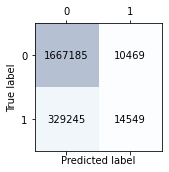

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [42]:
from xgboost import XGBClassifier

# 使用xgboost 建模，指定先前参数得到的节点深度限制使用xgboost 建模，指定先前调参得到的节点深度限制
model = XGBClassifier(tree_method = 'gpu_hist', n_jobs=-1, n_estimators=500, max_depth=11,use_label_encoder=False)
model.fit(X,y.values.ravel())
y_pred = model.predict(X)
print("Roc_auc_score: ",roc_auc_score(y,y_pred)*100,"%")

# 输出 confusion matrix
confmat = confusion_matrix(y_true=y, y_pred=y_pred, labels=[0, 1])

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()


In [ ]:
#  get submit file
submission = pd.read_csv(samplesubmision_file, compression='gzip', index_col='id')
submission[submission.columns[0]] = model.predict_proba(test)[:,1]
submission.to_csv('submission.csv')